# Analysis of NSF Abstracts

Here we show some practical Text Analysis with emphasis on Feature Engineering on the collection of NSF Award abstracts. Abstracts are generously available at **UCI Machine Learning Dataset** collection by **Michael J. Pazzani** (hope my citation is right!).

Each document consists of a research abstract along with metadata including the name of NSF department to which the abstract belongs. Here is an example of how these documents look like:


<img src="doc_ex.png" width="800">

As seen above, the funded research is on Mathematics and the department is Devision of Mathematical Science with tag **DMS**.

For sake of practicing, we exclude all meta data and only use abstract text to predict the department.

In [61]:
# Imports
import pandas as pd
from IPython.display import display
import os
import itertools
import re
import numpy as np
import matplotlib.pyplot as plt 
import pickle 
from collections import Counter
from sklearn.naive_bayes import MultinomialNB
import warnings
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk
warnings.simplefilter("ignore")


# Reading Raw Files

For sake of simplicity I used I processed data beforehand and here will just upload it but the process of reading files is in the **read_data** function for those who want to check.

In this showcase we use data only from **1990, 1995, 2000** and **a fraction of 1991, 1996 and 2001**. The complete dataset is from 1990 to 2003 with almost 129000 documents. 

In [62]:
def read_data(pfile=False, wrt=False):
    if pfile == True:
        data = pickle.load( open( "data.p", "rb" ) )
        return data
    d = {}

    ii = 0
    for dir1 in os.listdir("C:/Users/kasra.manshaei/Desktop/Feature Eng/Handouts/4. Feature Extraction/Text/Lab/NSF/"):
        print(dir1)
        for dir2 in os.listdir("C:/Users/kasra.manshaei/Desktop/Feature Eng/Handouts/4. Feature Extraction/Text/Lab/NSF/"+dir1):
            if 'links' not in dir2:
                for f in os.listdir("C:/Users/kasra.manshaei/Desktop/Feature Eng/Handouts/4. Feature Extraction/Text/Lab/NSF/"+dir1+'/'+dir2):
                    if 'links' not in f:
                        d[f] = []
                        fle = open("C:/Users/kasra.manshaei/Desktop/Feature Eng/Handouts/4. Feature Extraction/Text/Lab/NSF/"+dir1+'/'+dir2+'/'+f,'r')
                        content = ' '.join([ii.strip() for ii in fle.readlines()])
                        d[f].append(re.search(r'NSF Org(.*?)Latest', content).group(1).strip(': '))
                        d[f].append(content.split('Abstract')[1].strip(':  '))
                        fle.close()

    
    data = data.from_dict(d, orient='index')
    data.columns = ['Tag','Text']
    if wrt:
        pickle.dump( data, open( "data.p", "wb" ) )
    
    return data

Indices are the file names and two columns Text and Tag represent the research abstract and the department respectively. As you see bellow a part of abstracts are not available! The description of data even show more duplicate abstracts.

Let's go through them:

In [63]:
data = read_data(pfile=True)

# Have a look at how data is organized
display(data.head())

# Get a summary of data
display(data.describe())

,Tag,Text
a9000006.txt,DEB,Commercial exploitation over the past two hund...
a9000031.txt,MCB,Studies of chickens have provided serological ...
a9000038.txt,DMS,This research is part of an on-going program b...
a9000040.txt,DMI,This SBIR proposal is aimed at (1) the synthes...
a9000043.txt,OCE,Dr. Chisholm will investigate fundamental aspe...


,Tag,Text
count,37432,37432
unique,67,34160
top,DMS,Not Available
freq,3202,1494


In [64]:
# Search duplicates and take one from each
c = Counter(data['Text'])
for text,count in c.items():
    if count>1:
        inds = list(data.index[data['Text']==text])
        data.drop(inds[1::],axis=0,inplace=True)

In [65]:
# Get a summary of data again
display(data.describe())

,Tag,Text
count,34160,34160
unique,61,34160
top,DMS,9503384 Fuller The objective of this pr...
freq,2830,1


So the problem of duplicates is solved (in a blind way!) but is every abstract informative?

Let's explore short abstracts:

In [66]:
# Search short (probably not informative) abstracts
c = Counter(data['Text'])
for text, count in c.items():
    if len(text) < 100: # try with 1000 as well
        print(text)
        data.drop(data.index[data['Text']==text],axis=0,inplace=True)

Not Available
This action provides funds for NSF's use of the NIH Computer Facility for FY 1990.
This Interagency Agreement will provide training services for the Small Agency Council.
This Interagency Agreement will provide staff support for the Small Agency Council.

This is a grant to fund the 12th International CODATA Conference, Columbus, Ohio July 15-19, 1990.
This was a PI transfer so it was changed to standard grant and not a continuing grant.
Creative Enterprises
This is a 1989 Presidential Award for Excellence in Science and Mathematics Teaching
This is a renewal grant.//
This is a renewal.
This is just a test to see if this will go through.
This is a Presidential Young Investigator award.
JUSTIFICATION
Re:  DMS 95-00061, "Conference on Multiple Decision Theory and Related Topics"  PI:  James Berger
9500307 Bradley
9500831 Kennedy
This is an  abstract.
9500936 Propp
James Dumesic
9501101:  Andrews
9501528  Lawrence  Technical
9501529  Fisk  Technical
9501570  Liu
9501893 Grun

Proposal: DMS-9970376 Principal Investigator: Nathan S. Feldman
Proposal: DMS-9975469  PI: Tian-Jun Li
Proposal:  DMS-9973119  PI: Kium Ruane  Title: The Action of a CAT(0) Group on the Boundary
.
Proposal 0098331 Charles K Chui, Wenjie He, and Joachim Stoeckler U of Missouri, Saint Louis
MECHANICS OF SINGLE- AND MULTI-WALL CARBON NANOTUBES
Operator Theory and Inverse Problems
\
Technical
Proposal Processing and Data Entry Support for the Faculty Career Development (CAREER) Program
Anuj Srivastava 0101429
DMS Award
Postdoctoral Fellowship
DBI  0102111 John R. Spear
DMS-0102392 -
Proposal Number:   0103082  Principal Investigator:   Mehdi Asheghi
Complex Manifolds with special Structures,
Research on Stochastic Optimization and Applications  Hui Wang  Project
DMS-0103895  PI: Anthony M. Bloch  Dynamics and Control of Mechanical Systems
Administrative Support for the STC Integrative Partnerships Preproposal Panels
Problems in Surface Geometry and Topology
Koetter
EAR-0606257 Crayton J. Y

In [67]:
# Get a summary of data
display(data.describe())

,Tag,Text
count,33882,33882
unique,57,33882
top,DMS,9503384 Fuller The objective of this pr...
freq,2740,1


Before starting anything, we need to know how classes (here *Tags*) are distributed as a general aspect of data. Histograms are the right way to do this but here I would like to show more detailed information so I simply sort the class populations and plot it.

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 4, 5, 6, 7, 10, 13, 24, 32, 36, 37, 44, 77, 84, 190, 213, 215, 311, 338, 420, 476, 489, 528, 543, 581, 657, 691, 756, 1077, 1096, 1097, 1099, 1133, 1284, 1379, 1393, 1426, 1451, 1507, 1564, 1586, 1593, 1880, 1887, 1887, 2740]


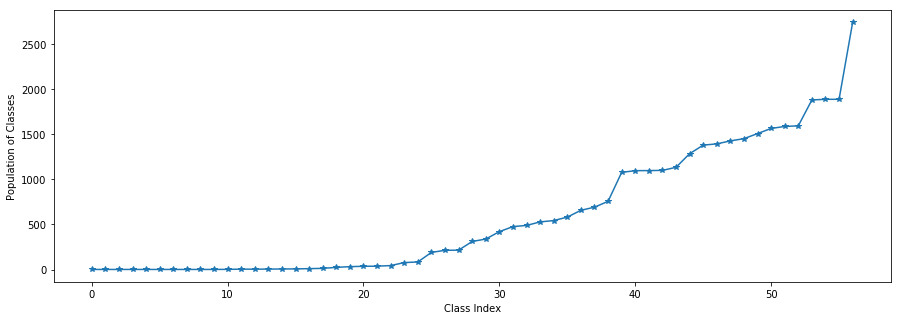

In [68]:
print(sorted(list(Counter(data['Tag'].tolist()).values())))
plt.figure(figsize=(15,5))
plt.plot(sorted(list(Counter(data['Tag'].tolist()).values())),'-*')
plt.ylabel('Population of Classes')
plt.xlabel('Class Index')
plt.show()


Now we can also check the histogram but we choose bins to put close class populations together.

[('DMS', 2740), ('EAR', 1887), ('DUE', 1887), ('INT', 1880), ('CHE', 1593), ('DMI', 1586), ('OCE', 1564), ('IBN', 1507), ('DMR', 1451), ('DEB', 1426), ('MCB', 1393), ('SES', 1379), ('BCS', 1284), ('DBI', 1133), ('CCR', 1099), ('ATM', 1097), ('PHY', 1096), ('CMS', 1077), ('ECS', 756), ('ESI', 691)]


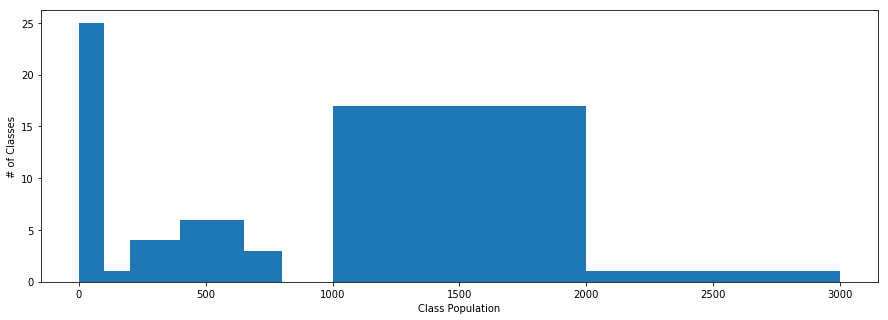

In [69]:
print(Counter(data['Tag'].tolist()).most_common(20))
plt.figure(figsize=(15,5))
plt.hist(list(Counter(data['Tag'].tolist()).values()),bins=[0,100,200,400,650,800,1000,2000,3000])
plt.ylabel('# of Classes')
plt.xlabel('Class Population')
plt.show()

Let's reduce problem to some classes with close number of samples according to the histogram above (**1000** to **2000**)

In [70]:
tags = [tag for tag in data.Tag.unique() if (len(data.loc[data['Tag']==tag])>1000 and len(data.loc[data['Tag']==tag])<2000)]
data = data[data.Tag.isin(tags)]
print(len(data),'samples from',len(tags),'classes')


24339 samples from 17 classes


Let's check the abstract length as well. It is a pretty naive feature but let's explore it:

minimum text length is: 105
maximum text length is: 7985
mean and median text lengths are: 1490.93890464 1351.0


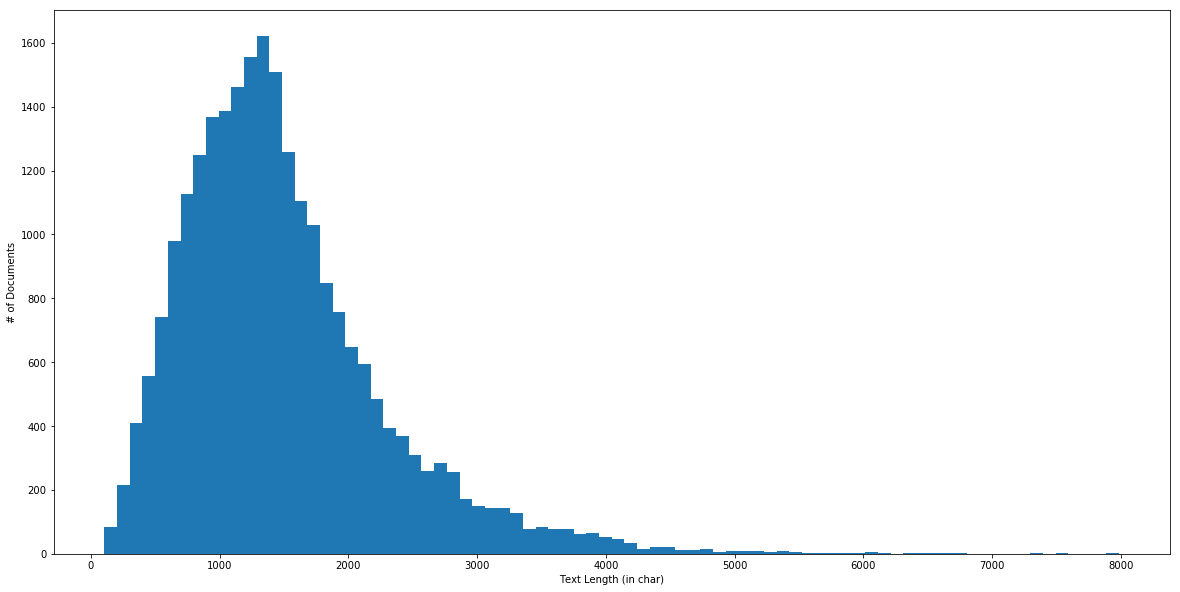

In [71]:
lens = [len(ii) for ii in data.Text]
print('minimum text length is:',np.min(lens))
print('maximum text length is:',np.max(lens))
print('mean and median text lengths are:',np.mean(lens),np.median(lens))
plt.figure(figsize=(20,10))
a=plt.hist(lens,bins=80)
plt.xlabel('Text Length (in char)')
plt.ylabel('# of Documents')
plt.show()


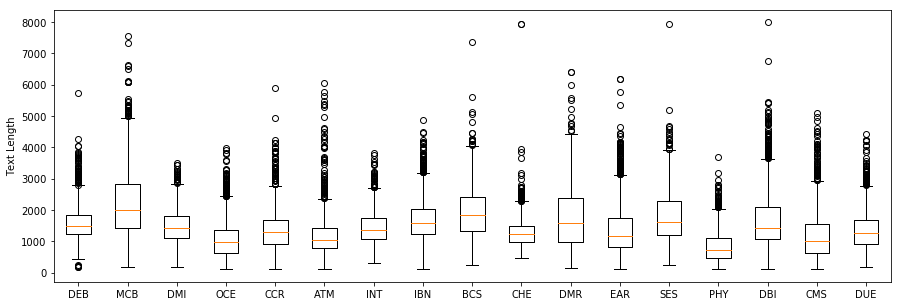

In [72]:
def len_of_tag(tag):
    return [len(ii) for ii in data[data.Tag == tag]['Text']]

tag_names = list(data.Tag.unique())

lengths = [len_of_tag(tag) for tag in tag_names]
plt.figure(figsize=(15,5))
plt.boxplot(lengths)
plt.ylabel('Text Length')
plt.xticks([ii for ii in range(1,18)], tag_names)
plt.show()


Well, we now have an almost balanced dataset of text on which we can apply our methods and see them in practice. Let's start with finding StopWords and important words. StopWords are non-informative words inside the corpus.

In [73]:
from nltk.tokenize import word_tokenize
c_total = Counter()
for ind in data.index:
    s = data.loc[ind].Text
    c_total.update(Counter(word_tokenize(s)))

In this container, we saved the number of occurances of each word. Let's have a look at it:

In [74]:
print(c_total.most_common(50))

[('the', 287980), ('of', 262709), (',', 214049), ('and', 211093), ('.', 205946), ('to', 132316), ('in', 118398), ('a', 83156), ('will', 78170), ('The', 59059), ('is', 56329), ('for', 55943), ('be', 49778), (')', 45001), ('(', 39504), ('that', 36607), ('on', 34477), ('are', 33425), ('research', 31397), ('with', 31369), ('by', 29061), ('as', 28296), ('This', 28047), ('this', 26986), ('from', 22690), ('at', 20457), ('an', 19421), ('project', 19135), ('which', 17741), ('these', 15274), ('have', 13708), ('study', 12245), ('data', 12018), ('new', 11903), (';', 11901), ('has', 11827), ('or', 11591), ('their', 11556), ('can', 10144), (':', 9680), ('used', 9611), ('In', 9273), ('provide', 9224), ('such', 9146), ('students', 9082), ('between', 9041), ('other', 8770), ('studies', 8709), ('also', 8704), ('University', 8540)]


Now we check the number of times each word appeared in **different documents (Document Frequency)**. This reveals a part of our **curpos-based StopWord** list:

In [75]:
from nltk.tokenize import word_tokenize
c_unique = Counter()
for ind in data.index:
    s = data.loc[ind].Text
    c_unique.update(Counter(set(word_tokenize(s))))

In [76]:
print(c_unique.most_common(50))

for word in c_unique.most_common(50):
    print(word[0],'-->', np.round(100*word[1]/len(data),2),'%')

[('.', 24287), ('of', 24147), ('the', 24138), ('and', 24110), (',', 23566), ('to', 23528), ('in', 23176), ('a', 21806), ('The', 21226), ('will', 20371), ('is', 19766), ('for', 19617), ('be', 17790), ('This', 17237), ('on', 16217), ('with', 15672), ('are', 15077), ('by', 14777), ('that', 14685), ('this', 14356), (')', 14302), ('research', 14128), ('(', 13805), ('as', 13260), ('from', 12757), ('an', 12031), ('at', 11432), ('project', 10945), ('which', 10331), ('these', 9291), ('have', 8659), ('study', 8092), ('has', 7725), ('new', 7442), ('their', 7323), ('or', 7169), ('provide', 6882), ('used', 6851), ('In', 6842), ('also', 6676), (':', 6645), ('can', 6593), ('such', 6502), ('between', 6480), ('other', 6465), ('understanding', 6318), ('data', 6182), ('important', 6178), ('use', 6122), ('studies', 5781)]
. --> 99.79 %
of --> 99.21 %
the --> 99.17 %
and --> 99.06 %
, --> 96.82 %
to --> 96.67 %
in --> 95.22 %
a --> 89.59 %
The --> 87.21 %
will --> 83.7 %
is --> 81.21 %
for --> 80.6 %
be --

and what about the total number of words?

In [77]:
print(len(c_unique),'unique words i.e. the complete size of our vocab. This is the dimension of our BoW representation.')

print(np.sum(list(c_total.values())), 'words in total (with repeatations) i.e. sum of BoW matrix.')

133707 unique words i.e. the complete size of our vocab. This is the dimension of our BoW representation.
5808218 words in total (with repeatations) i.e. sum of BoW matrix.


Let's check the class-based specification of each word:

In [78]:
tag_dict = {tag:Counter() for tag in data.Tag.unique()}
for ind in data.index:
    tag = data.loc[ind]['Tag']
    s = data.loc[ind].Text
    tag_dict[tag].update(Counter(set(word_tokenize(s))))

In [79]:
for tag in tag_dict:
    print('most common words for',tag)
    print('--------------------------')
    len_tag = len(data[data['Tag']==tag])
    for word in tag_dict[tag].most_common(20):
        print(word[0],'-->', np.round(100*word[1]/len_tag,2),'%')
    print()

most common words for DEB
--------------------------
. --> 99.86 %
and --> 99.72 %
of --> 99.65 %
the --> 99.58 %
, --> 99.16 %
to --> 98.04 %
in --> 97.41 %
will --> 95.44 %
a --> 91.8 %
The --> 85.62 %
be --> 80.43 %
for --> 79.66 %
is --> 79.59 %
are --> 75.67 %
that --> 75.6 %
on --> 74.47 %
this --> 66.97 %
This --> 64.59 %
) --> 64.17 %
by --> 62.97 %

most common words for MCB
--------------------------
. --> 99.93 %
and --> 99.14 %
of --> 98.71 %
the --> 98.64 %
to --> 98.06 %
in --> 97.77 %
, --> 97.77 %
a --> 94.4 %
is --> 91.89 %
The --> 91.1 %
will --> 90.24 %
be --> 86.29 %
for --> 84.64 %
are --> 80.69 %
that --> 80.69 %
this --> 77.53 %
by --> 77.32 %
with --> 73.3 %
) --> 72.43 %
( --> 70.35 %

most common words for DMI
--------------------------
. --> 100.0 %
of --> 99.5 %
and --> 99.31 %
the --> 99.18 %
, --> 98.05 %
to --> 97.98 %
a --> 94.39 %
in --> 93.38 %
for --> 92.62 %
will --> 90.67 %
The --> 89.03 %
be --> 85.31 %
This --> 83.54 %
is --> 82.35 %
) --> 72.76 %

Now I repeat the same but this time let's remove some of the found StopWord. Please note that we did not found all stop words yet, we did not clean data in any sense (e.g. removing punctuations, numbers, special characters, lower-upper case normalization, etc.)

In [56]:
for n_stop_words in [50,500,5000]:
    print('With',n_stop_words,'stop-words ##############')
    StopWords = [ii[0] for ii in c_unique.most_common(n_stop_words)]
    for tag in tag_dict:
        print('most common words for',tag)
        print('--------------------------')
        len_tag = len(data[data['Tag']==tag])
        jj = 0
        for word in tag_dict[tag].most_common(2*n_stop_words):
            if word[0] not in StopWords:
                print(word[0],'-->', np.round(100*word[1]/len_tag,2),'%')
                jj += 1
            if jj == 20:
                break
                
        print()
    print('\n\n')

With 50 stop-words ##############
most common words for DEB
--------------------------
species --> 60.03 %
been --> 33.38 %
plant --> 29.73 %
among --> 28.89 %
how --> 27.63 %
evolutionary --> 26.86 %
two --> 26.37 %
may --> 25.95 %
plants --> 25.95 %
natural --> 25.46 %
many --> 25.25 %
populations --> 24.75 %
determine --> 24.75 %
within --> 24.68 %
different --> 24.54 %
These --> 24.26 %
evolution --> 23.77 %
test --> 23.7 %
genetic --> 23.56 %
proposed --> 23.56 %

most common words for MCB
--------------------------
protein --> 49.82 %
been --> 46.16 %
proteins --> 45.51 %
molecular --> 44.08 %
function --> 40.7 %
into --> 39.48 %
it --> 37.9 %
cell --> 37.04 %
gene --> 36.54 %
These --> 34.96 %
specific --> 34.75 %
its --> 34.53 %
structure --> 34.17 %
role --> 33.96 %
two --> 33.31 %
cells --> 33.24 %
how --> 33.09 %
A --> 32.95 %
genes --> 32.16 %
not --> 31.73 %

most common words for DMI
--------------------------
Phase --> 53.97 %
Research --> 50.69 %
I --> 47.35 %
Small -->

feasibility --> 16.08 %
industrial --> 14.69 %
prototype --> 14.0 %
product --> 13.56 %
devices --> 12.74 %
If --> 12.48 %
market --> 12.36 %
demonstrate --> 11.54 %
efficient --> 11.48 %
demonstrated --> 10.91 %
power --> 10.72 %

most common words for OCE
--------------------------
ocean --> 32.8 %
marine --> 21.29 %
Ocean --> 17.9 %
Pacific --> 16.69 %
operated --> 12.72 %
Atlantic --> 12.66 %
vessel --> 12.15 %
carbon --> 11.45 %
oceanographic --> 11.06 %
sea --> 10.81 %
circulation --> 10.81 %
oceanic --> 10.04 %
ship --> 9.85 %
deep --> 9.85 %
waters --> 9.53 %
sediments --> 9.46 %
shipboard --> 9.27 %
variability --> 9.21 %
collected --> 8.7 %
sediment --> 8.7 %

most common words for CCR
--------------------------
algorithms --> 39.67 %
efficient --> 24.02 %
parallel --> 18.56 %
computational --> 17.11 %
implementation --> 16.01 %
complexity --> 15.74 %
programming --> 15.1 %
communication --> 15.01 %
computing --> 14.01 %
computation --> 13.83 %
practical --> 12.83 %
distribut

Interesting ...!
Let's go on by doing the same but this time with calculating some information theoretic score for each word to be selected as a feature (feature importance, ranking, selection, blahblah). Later we can compare the performance of our methods on these words with the performance of the same models on other feature sets like BoW variations.

The score is calculated based on the intuitive idea bellow

### How class-informative is a word? i.e. how confident you can predict the class of a text if you see this word in it?

To do this we calculate an information-theoretic inspired score as follows:

$$\large S(w_{i}) = \frac{1}{N_{c}-1}\times\frac{N_{c}-N_{w_{i},c}}{N_{w_{i},c}} $$

where $N_{w,c}$ is the number of classes in which the word $w_{i}$ appeard, and $N_{c}$ is the total number of classes. This score is bounded between $0$ and $1$ (I confess that I complicated a simple concept too much but it became beatiful at least :P ).

## Advantage
* Captures the most distingushable words.
* Does not need normalization by class sizes as it looks at word appearence in a binary way.

## Disadvantage
* Pretty naive idea! Of course the total number of appearences in classes is more informative than *if the word $w$ ever appeared in class $c$ or not*.
 * Just assume the case that a word appears in $N_{c}-1$ classes only once and in one class $10k$ times.
 
 
* Danger zone! The features captured here are pretty special such that do not capture an unseen document in general (overfitting problem).
 * **Solution**: randomly add not-so-special words to this dictionary to improve generalization (doesn't looks like Regularization?!).
* It **CAN NOT** consider all classes i.e. the score **DOES NOT** tell to which class a word belongs!
 * A slight modification on the formulation can solve this problem. In this case we calculate the top $n$ best words for each class and concatenate them to construct feature vector **(It will become a supervised version of what we know as TF-IDF :) )**

In [123]:
# tags = data.Tag.unique().tolist()
# vocabs = {}
# for tag in tags:
#     print(tag)
#     data_tmp = data[data.Tag==tag]
#     vocabs[tag] = set(nltk.tokenize.word_tokenize(data_tmp['Text'].str.cat(sep=' ')))

    
    
from nltk.tokenize import word_tokenize
vocabs = Counter()
for tag in tags:
    s = data[data.Tag == tag].Text.str.cat(sep=' ')
    vocabs.update(Counter(set(word_tokenize(s))))

DEB
MCB
DMI
OCE
CCR
ATM
INT
IBN
BCS
CHE
DMR
EAR
SES
PHY
DBI
CMS
DUE


In [136]:
word_scores = {}
for word in c_unique.keys():
    N_wc=np.sum([1 for tag in tags if word in vocabs[tag]])
    word_scores[word] = (1./16.)*(17.-N_wc)/N_wc


import operator
sorted_word_scores = sorted(word_scores.items(), key=operator.itemgetter(1))
print('Some low-score examples:\n')
print(sorted_word_scores[0:100],'\n')
print('Some high-score examples:\n')
print(sorted_word_scores[-100::])


Counter(list(word_scores.values()))

Some low-score examples:

[('to', 0.0), ('comparing', 0.0), ('two', 0.0), ('species', 0.0), ('distributions', 0.0), ('characteristics', 0.0), ('genetic', 0.0), ('context', 0.0), ('by', 0.0), ('in', 0.0), ('history', 0.0), ('further', 0.0), ('population', 0.0), ('different', 0.0), ('regarding', 0.0), ('effect', 0.0), ('minimal', 0.0), ('during', 0.0), ('carried', 0.0), ('international', 0.0), ('these', 0.0), ('pattern', 0.0), ('isolation', 0.0), ('information', 0.0), ('Additional', 0.0), ('a', 0.0), ('The', 0.0), ('out', 0.0), ('near', 0.0), ('at', 0.0), ('prior', 0.0), ('permit', 0.0), ('smaller', 0.0), ('management', 0.0), ('level', 0.0), ('the', 0.0), ('analyses', 0.0), ('distribution', 0.0), ('past', 0.0), ('of', 0.0), ('structure', 0.0), ('on', 0.0), ('facilitate', 0.0), ('distinct', 0.0), ('studies', 0.0), ('among', 0.0), ('size', 0.0), ('has', 0.0), ('Each', 0.0), ('over', 0.0), ('but', 0.0), ('appear', 0.0), ('its', 0.0), ('study', 0.0), ('this', 0.0), ('flow', 0.0), ('years', 0

Counter({0.0: 2419,
         0.00390625: 803,
         0.0083333333333333332: 692,
         0.013392857142857142: 669,
         0.019230769230769232: 686,
         0.026041666666666668: 760,
         0.034090909090909088: 796,
         0.043749999999999997: 893,
         0.055555555555555552: 1058,
         0.0703125: 1214,
         0.089285714285714288: 1486,
         0.11458333333333333: 1981,
         0.14999999999999999: 2555,
         0.203125: 3943,
         0.29166666666666669: 6549,
         0.46875: 14830,
         1.0: 92373})

Now I want to see how many times each of those high-scored words appeared in its own class. By now I just check $\{w_{i} | S(w_{i})=1\}$.

In [150]:
# words = {word:0 for word in word_scores if word_scores[word]==1}
# ii = 0
# for word in words:
#     words[word] = data.Text.str.contains(word).sum() / len(data[data.Tag == data[data.Text.str.contains(word)].Tag.unique()[0]])
#     ii += 1
#     if ii%10 == 0:
#         print(ii)
data.Text.str.contains('.').sum()
#data[data.Text.str.contains('demographic')].Tag.unique().tolist()

24339

In [129]:
# import operator
# sorted_word_scores = sorted(word_scores.items(), key=operator.itemgetter(1))
# print('Some bad features:\n')
# print(sorted_word_scores[0:100])
# print('Some good features:\n')
# print(sorted_word_scores[-100::])



# print(len(tmp))
# print()

word = 'random-cluster'
print(data[data.Text.str.contains(word)])
tmp = data[data.Text.str.contains(word)]
print([1 for tag in tags if word in vocabs[tag]])
N_wc = np.sum([1 for ii in tags if word in vocabs[tag]])
word_scores[word] = (1./16.)*(17.-N_wc)/17.

'random-cluster' in vocabs['DMR']

              Tag                                               Text
a0110903.txt  DMR  0110903 Yu This is a SGER award to support the...
[1]


True

Interesting ...!

So far it gives this impression that with a slight cleaning we get a pretty discriminative set of features. We will get to that point soon.
Now let's check some embedding and then some classification. After that we clean data more and probably increase the performance of our unsupervised/supervised methods.

So let's continue with some embedding in this current **dirty** data.

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

class DenseTransformer():

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self



# Split data into train/test
train = data.sample(frac=0.75)
train_x = train.Text
train_y = train.Tag
test = data[~data.index.isin(train.index)]
test_x = test.Text
test_y = test.Tag

TFIDF = TfidfVectorizer()
BoW = CountVectorizer()

LLE = LocallyLinearEmbedding(n_components=1000, n_neighbors=3, eigen_solver='arpack')

clf = svm.SVC(kernel='rbf')



BoW_LLE_SVM = Pipeline([('BoW', BoW), ('to_dense', DenseTransformer()), ('LLE', LLE), ('SVM', clf)])
TFIDF_LLE_SVM = Pipeline([('TFIDF', TFIDF), ('to_dense', DenseTransformer()), ('LLE', LLE), ('SVM', clf)])

BoW_LLE_SVM.fit(train_x, train_y)
print("BoW_LLE_SVM is fitted!")
TFIDF_LLE_SVM.fit(train_x, train_y)
print("TFIDF_LLE_SVM is fitted!")

BoW_LLE_SVM_preds = BoW_LLE_SVM.predict(test_x)
print("BoW_LLE_SVM is done!")
TFIDF_LLE_SVM_preds = TFIDF_LLE_SVM.predict(test_x)
print("TFIDF_LLE_SVM is done!")

print('Results of BoW_LLE_SVM')
print(classification_report(test_y, BoW_LLE_SVM_preds))
print('Results of TFIDF_LLE_SVM')
print(classification_report(test_y, TFIDF_LLE_SVM_preds))

In [123]:
## In this part we assume file data.p is already in the workspace so we can just load it.

# d = pickle.load( open( "data.p", "rb" ) )
# d.drop(['a9103601.txt', 'a9530727.txt'],inplace=True) # No abstract available for these two papers
d=data
a = d['Tag'].tolist()
print(Counter(a)) # Class populations

# # Class populations as Histogram and simple Plot
# plt.figure(figsize=(12,4))
# plt.subplot(121)
# plt.hist(list(Counter(a).values()),bins=50)
# plt.subplot(122)
# plt.plot(sorted(list(Counter(a).values())),'*')
# plt.show()
train = d.sample(round(len(d)*.7))
test = d[~d.index.isin(train.index)]
# print(train,test)
# print(len(train)+len(test))
print(d[d['Tag']=='DUE'])

Counter({'EAR': 1887, 'DUE': 1887, 'INT': 1880, 'CHE': 1593, 'DMI': 1586, 'OCE': 1564, 'IBN': 1507, 'DMR': 1451, 'DEB': 1426, 'MCB': 1393, 'SES': 1379, 'BCS': 1284, 'DBI': 1133, 'CCR': 1099, 'ATM': 1097, 'PHY': 1096, 'CMS': 1077})
              Tag                                               Text
a9050015.txt  DUE  The purpose of this five-year project is to de...
a9050016.txt  DUE  The project's focus is the development and eva...
a9050017.txt  DUE  The University of Wyoming project is to develo...
a9050020.txt  DUE  The University of Wisconsin--Milwaukee will de...
a9050024.txt  DUE  The purpose of this project is to radically mo...
a9050025.txt  DUE  The University of Nebraska will undertake a pr...
a9050028.txt  DUE  California State University, Long Beach, will ...
a9050032.txt  DUE  The Construction of Elementary Mathematics Pro...
a9050039.txt  DUE  Indiana University will establish a comprehens...
a9050042.txt  DUE  A symposium will be convened at the National T...
a9050329.t

In [ ]:
d = train
data_samples = d['Text'].tolist() #fetch_20newsgroups(shuffle=True, random_state=1,remove=('headers', 'footers', 'quotes'))
#data_samples = dataset.data[:5]
#print(data_samples)
print(data_samples.count('Not Available'))
seg = d.loc[d['Text'] == 'Not Available']
from collections import Counter
cnt = Counter(seg['Tag'].tolist())
tgs = list(set(d['Tag'].tolist()))
for item in cnt:
    if (cnt[item] / len(d[d['Tag']==item])) > .15:
        tgs.remove(item)
        print(item,'-->', np.round(100*cnt[item] / len(d[d['Tag']==item]),2),'%','over ',str(len(d[d['Tag']==item])),'samples')
        
print(len(tgs))

In [ ]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
#                                    max_features=700,
#                                    stop_words='english')
# #t0 = time()
# tfidf = tfidf_vectorizer.fit_transform(data_samples)

In [ ]:
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=700,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data_samples)

In [ ]:

n_components = 10    
n_top_words = 20


# tf-idf + NMF
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (0, 0))
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % 0)

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)



In [ ]:
# CountVectorize + LDA
lda = LatentDirichletAllocation(n_topics=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(tf)
print("done in %0.3fs." % 999999999999999)

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

In [ ]:
model = MultinomialNB()
X = tf.toarray()
y = np.array(train['Tag'].tolist())
model.fit(X, y)
acc = 0.0
X_new = tf_vectorizer.transform(test['Text'].tolist()).toarray()
true_lab = test['Tag'].tolist()
for ii in range(len(X_new)):
    if model.predict(X_new[ii,:]) == true_lab[ii]:
        acc += 1.0

print('accuracy is: ',100.0*acc/float(len(test)),'%')       



In [ ]:
## In this part we assume file data.p is already in the workspace so we can just load it.

d = pickle.load( open( "data.p", "rb" ) )
d.drop(['a9103601.txt', 'a9530727.txt'],inplace=True)
acc_plot = []
std_plot = []
for fs in [1000,2000,3000,4000,7000,10000]:
    tmp_acc = []
    for rpt in range(3):
        train = d.sample(round(len(d)*.7))
        test = d[~d.index.isin(train.index)]

        
        data_samples = train['Text'].tolist()

        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                        max_features=fs,
                                        stop_words='english')
        tf = tf_vectorizer.fit_transform(data_samples)

        model = MultinomialNB()
        X = tf.toarray()
        y = np.array(train['Tag'].tolist())
        model.fit(X, y)
        acc = 0.0
        X_new = tf_vectorizer.transform(test['Text'].tolist()).toarray()
        true_lab = test['Tag'].tolist()
        for ii in range(len(X_new)):
            if model.predict(X_new[ii,:]) == true_lab[ii]:
                acc += 1.0
        tmp_acc.append(100.0*acc/float(len(test)))
    print(tmp_acc)
    acc_plot.append(np.mean(tmp_acc))
    std_plot.append(np.std(tmp_acc))
    print('accuracy is: ',np.around(np.mean(tmp_acc),decimals=2),'%')      

plt.figure(figsize=(12,12))
plt.errorbar([1000,2000,3000,4000,7000,10000],acc_plot, yerr=std_plot, fmt='o')
# plt.figure(figsize=(12,12))
# plt.plot([1000,2000,3000,4000,7000,10000],acc_plot,'-*',linewidth=3,ms=5)
# plt.plot([1000,2000,3000,4000,7000,10000],std_plot,'-s',linewidth=3,ms=5)
plt.show()

In [ ]:
## In this part we assume file data.p is already in the workspace so we can just load it.

d = pickle.load( open( "data.p", "rb" ) )
d.drop(['a9103601.txt', 'a9530727.txt'],inplace=True)
acc_plot = []
std_plot = []
for fs in [1000,2000,3000,4000,7000,10000]:
    tmp_acc = []
    for rpt in range(3):
        train = d.sample(round(len(d)*.7))
        test = d[~d.index.isin(train.index)]

        
        data_samples = train['Text'].tolist()

        tf_vectorizer = CountVectorizer(max_df=0.80, min_df=2,
                                        max_features=fs,
                                        stop_words='english')
        tf = tf_vectorizer.fit_transform(data_samples)

        model = MultinomialNB()
        X = tf.toarray()
        y = np.array(train['Tag'].tolist())
        model.fit(X, y)
        acc = 0.0
        X_new = tf_vectorizer.transform(test['Text'].tolist()).toarray()
        true_lab = test['Tag'].tolist()
        for ii in range(len(X_new)):
            if model.predict(X_new[ii,:]) == true_lab[ii]:
                acc += 1.0
        tmp_acc.append(100.0*acc/float(len(test)))
    print(tmp_acc)
    acc_plot.append(np.mean(tmp_acc))
    std_plot.append(np.std(tmp_acc))
    print('accuracy is: ',np.around(np.mean(tmp_acc),decimals=2),'%')      

plt.figure(figsize=(12,12))
plt.errorbar([1000,2000,3000,4000,7000,10000],acc_plot, yerr=std_plot, fmt='o')
# plt.figure(figsize=(12,12))
# plt.plot([1000,2000,3000,4000,7000,10000],acc_plot,'-*',linewidth=3,ms=5)
# plt.plot([1000,2000,3000,4000,7000,10000],std_plot,'-s',linewidth=3,ms=5)
plt.show()

In [ ]:
d = pickle.load( open( "data.p", "rb" ) )
d.drop(['a9103601.txt', 'a9530727.txt'],inplace=True)
acc_plot = []
std_plot = []
for fs in [10000]:
    tmp_acc = []
    for rpt in range(3):
        train = d.sample(round(len(d)*.7))
        test = d[~d.index.isin(train.index)]

        
        data_samples = train['Text'].tolist()

        tf_vectorizer = CountVectorizer(max_df=0.99, min_df=0.0,
                                        max_features=fs,
                                        stop_words='english')
        tf = tf_vectorizer.fit_transform(data_samples)

        model = svm.SVC()
        X = tf.toarray()
        y = np.array(train['Tag'].tolist())
        model.fit(X, y)
        acc = 0.0
        X_new = tf_vectorizer.transform(test['Text'].tolist()).toarray()
        true_lab = test['Tag'].tolist()
        
        tmp_acc.append(model.score(X_new,true_lab))
        print('done!')
    print(tmp_acc)
    acc_plot.append(np.mean(tmp_acc))
    std_plot.append(np.std(tmp_acc))
    print('accuracy is: ',np.around(np.mean(tmp_acc),decimals=2),'%')

# plt.figure(figsize=(12,12))
# plt.errorbar([1000,2000,3000,4000,7000,10000],acc_plot, yerr=std_plot, fmt='o')
# # plt.figure(figsize=(12,12))
# # plt.plot([1000,2000,3000,4000,7000,10000],acc_plot,'-*',linewidth=3,ms=5)
# # plt.plot([1000,2000,3000,4000,7000,10000],std_plot,'-s',linewidth=3,ms=5)
# plt.show()

In [34]:
data.loc['a0104004.txt'].Text

'DMS-0104004 Alexander A. Voronov  The goal of the project is to discover and study new algebraic structures in topology suggested or motivated by mathematical physics, in particular, quantum field theory and string theory.  More specifically, the project aims at discovering a new algebraic structure on the homology of an n-sphere space, by which we mean the space of continuous maps from the n-dimensional sphere to a given manifold. This part of the project, joint with Dennis Sullivan, generalizes the work pioneered by Chas and Sullivan in the case n=1, i.e., that of a usual free loop space. Another goal is to establish connection between Chas-Sullivan\'s work and Gromov-Witten invariants, which we believe to be a holomorphic version of Chas-Sullivan\'s algebraic structure. Gromov-Witten invariants come from sigma model of quantum field theory, and Chas-Sullivan\'s work "String Topology" may be regarded as a topological version of the physical construction. This part of the project is 